In [0]:
from google.colab import files
uploaded=files.upload()

Saving Books.csv to Books.csv
Saving Ratings.csv to Ratings.csv
Saving Users.csv to Users.csv


In [0]:
import pandas as pd 
import matplotlib as plt 
import os, sys
import re
import numpy as np 
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
import ipywidgets as widgets
from IPython.display import display,clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import re 
import seaborn as sns

In [4]:
import sklearn.metrics as metrics
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [8]:
books=pd.read_csv('Books.csv',sep=';',error_bad_lines=False,encoding='latin-1')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [0]:
books.columns=['ISBN','booktitle','bookAuthor','yearofpulblication','publisher','imageurls','imageurlm','imageurl']

In [11]:
books.head()


,ISBN,booktitle,bookAuthor,yearofpulblication,publisher,imageurls,imageurlm,imageurl
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [0]:
users=pd.read_csv('Users.csv',sep=';',encoding='latin-1')

In [15]:
users.columns=['userID','Location','Age']
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [0]:
ratings=pd.read_csv('Ratings.csv',sep=';',encoding='latin-1')
ratings.coloumns=['userId','ISBN','bookRating']

In [18]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


In BOOks we find that urls columns do not seems to be required for analysis thus we can drop the coloumns 

In [19]:
books.drop(['imageurls','imageurlm','imageurl'],axis=1,inplace=True)
books.head()

,ISBN,booktitle,bookAuthor,yearofpulblication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [20]:
books.dtypes

ISBN                  object
booktitle             object
bookAuthor            object
yearofpulblication    object
publisher             object
dtype: object

In [0]:
pd.set_option('display.max_colwidth',-1)

In [22]:
books.yearofpulblication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

There are some incorrect entries in yearOfPublication. It looks like publisher names ‘DK Publishing Inc’ and ‘Gallimard’ have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file. Also, some of the values are strings and same years have been entered as numbers at some places. We will make necessary correction for these rows and set the data type for yearOfPublication as int.

In [23]:
books.loc[books['yearofpulblication']=='DK Publishing Inc']

,ISBN,booktitle,bookAuthor,yearofpulblication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [0]:
books.loc[books['ISBN']== '0789466953','yearofpulblication']=2000
books.loc[books['ISBN']== '0789466953','publisher']='DK Publishing Inc'
books.loc[books['ISBN']== '0789466953','bookAuthor']='James Buckley'
books.loc[books['ISBN']== '0789466953','booktitle']='DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'


In [0]:
books.loc[books['ISBN']== '0789466953','yearofpulblication']=2000
books.loc[books['ISBN']== '0789466953','publisher']='DK Publishing Inc'
books.loc[books['ISBN']== '0789466953','bookAuthor']='Michael Teitelbaum'
books.loc[books['ISBN']== '0789466953','booktitle']='DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'


In [27]:
books.loc[books['yearofpulblication']=='Galimard']

,ISBN,booktitle,bookAuthor,yearofpulblication,publisher


In [28]:
books.loc[books.ISBN=='2070426769']

,ISBN,booktitle,bookAuthor,yearofpulblication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [0]:
books.loc[books['ISBN']== '2070426769','yearofpulblication']=2003
books.loc[books['ISBN']== '2070426769','publisher']='Gallimard'
books.loc[books['ISBN']== '2070426769','bookAuthor']='Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books['ISBN']== '2070426769','booktitle']='Peuple du ciel, suivi de Les Bergers'


In [0]:
books['yearofpulblication']=pd.to_numeric(books['yearofpulblication'],errors='coerce')


In [31]:
print(sorted(books['yearofpulblication'].unique()))

[0.0, 1376.0, 1378.0, 1806.0, 1897.0, 1900.0, 1901.0, 1902.0, 1904.0, 1906.0, 1908.0, 1909.0, 1910.0, 1911.0, 1914.0, 1917.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2008.0, 2010.0, 2011.0, 2012.0, 2020.0, 2021.0, 2024.0, 2026.0, 2030.0, 2037.0, 2038.0, 2050.0, nan]


In [0]:
books.loc[(books.yearofpulblication>2006) |(books.yearofpulblication==0),'yearofpulblication']=np.NAN 

In [34]:
(books['yearofpulblication'])

0         2002.0
1         2001.0
2         1991.0
3         1999.0
4         1999.0
5         1991.0
6         2000.0
7         1993.0
8         1996.0
9         2002.0
10        1988.0
11        2000.0
12        2004.0
13        1999.0
14        1998.0
15        1998.0
16        1999.0
17        1994.0
18        1999.0
19        1994.0
20        1999.0
21        2001.0
22        2003.0
23        2000.0
24        1999.0
25        1998.0
26        2004.0
27        1997.0
28        2000.0
29        1996.0
           ...  
271330    1990.0
271331    1997.0
271332    1993.0
271333    1994.0
271334    2001.0
271335    1989.0
271336    1995.0
271337    2002.0
271338    1997.0
271339    2003.0
271340    2003.0
271341    1998.0
271342    2001.0
271343    1998.0
271344    1999.0
271345    1999.0
271346    1978.0
271347    2000.0
271348    2003.0
271349    2004.0
271350    2002.0
271351    2001.0
271352    2004.0
271353    1975.0
271354    1993.0
271355    1988.0
271356    1991.0
271357    2004

In [0]:
books.yearofpulblication.fillna(round(books.yearofpulblication.mean()),inplace=True)
books.yearofpublication=books.yearofpulblication.astype(np.int32)

In [36]:
books

,ISBN,booktitle,bookAuthor,yearofpulblication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Historians Imagine What Might Have Been,Robert Cowley,2000.0,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993.0,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Reality of Life Among the Pirates,David Cordingly,1996.0,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner


In [37]:
books.isnull().any()

ISBN                  False
booktitle             False
bookAuthor            True 
yearofpulblication    False
publisher             True 
dtype: bool

In [38]:
books.isnull().any().sum()

2

In [39]:
books.loc[books['publisher'].isnull()]

,ISBN,booktitle,bookAuthor,yearofpulblication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN


In [0]:
books.loc[(books.ISBN=='193169656X'),'publisher']='other'
books.loc[(books.ISBN=='1931696993'),'publisher']='other'

In [0]:
books.loc[(books.ISBN=='9627982032'),'bookAuthor']='others' 

Users Dataset
Now we explore users dataset, firstly by checking its shape, first few columns and data types.

In [42]:
print(users.shape)

(278858, 3)


In [43]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [44]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In my view ages below 5 and above 90 do not make much sense, and hence, these are being replaced with NaNs. All the NaNs are then replaced with mean value of Age, and its data type is set as int.

In [0]:
users.loc[(users['Age']<5)|(users['Age']>90),'Age']=np.NAN

In [0]:
users.Age=users.Age.fillna(users.Age.mean())
users.Age=users.Age.astype(np.int32)

In [47]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",34
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",34
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",34


**Rating Dataset**


We check the ratings dataset for its shape and first few rows. It reveals that our user-book ratings matrix will be very sparse as actual ratings are quite less as compared to size of ratings matrix (number of users × number of books).

In [48]:
ratings.shape

(1149780, 3)

In [49]:
n_users=users.shape[0]
n_books=users.shape[0]
print(n_users*n_books)

77761784164


In [50]:
ratings.head(10)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


Now ratings dataset should have userID and ISBN which exist in respective tables, viz. users and books.

In [51]:
ratings.rename(columns={'User-ID':'userID'})

,userID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [52]:
ratings_new=ratings[ratings.ISBN.isin(books.ISBN)]
ratings_new
ratings_new.rename(columns={'User-ID':'userid'},inplace=True)
ratings_new

,userid,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
8,276744,038550120X,7
10,276746,0425115801,0
11,276746,0449006522,0
12,276746,0553561618,0


In [54]:
ratings_new=ratings_new[ratings_new['userid'].isin(users.userID)]
ratings_new

,userid,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
8,276744,038550120X,7
10,276746,0425115801,0
11,276746,0449006522,0
12,276746,0553561618,0


In [55]:
print(ratings.shape)
print(ratings_new.shape)

(1149780, 3)
(1031136, 3)


It is evident that users have rated some books which are not the part of original books

In [57]:
sparsity =1-len(ratings_new)/float(n_users*n_books)
print(sparsity)

0.9999867398104212


In [58]:
print("The sparsity of Book Crossing dataset is "+str(sparsity*100)+'%')

The sparsity of Book Crossing dataset is 99.99867398104212%


The explicit ratings represented by 1–10 and implicit ratings represented by 0 will have to be segregated now. We will be using only explicit ratings for building our book recommendation system. Similarly, users are also segregated into those who rated explicitly and those whose implicit behavior was recorded.

In [60]:
ratings.rename(columns={'Book-Rating':'BookRating'},inplace=True)
ratings_new.rename(columns={'Book-Rating':'BookRating'},inplace=True)
ratings.BookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [0]:
ratings_explicit=ratings_new[ratings_new.BookRating!=0]
ratings_implicit=ratings_new[ratings_new.BookRating==0]


In [65]:
ratings_explicit

,userid,ISBN,BookRating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
21,276747,0943066433,7
23,276747,1885408226,7
24,276748,0747558167,6


In [67]:
ratings_implicit

,userid,ISBN,BookRating
0,276725,034545104X,0
2,276727,0446520802,0
5,276733,2080674722,0
10,276746,0425115801,0
11,276746,0449006522,0
12,276746,0553561618,0
13,276746,055356451X,0
14,276746,0786013990,0
15,276746,0786014512,0
17,276747,0451192001,0


In [0]:
user_exp_ratings=users[users.userID.isin(ratings_explicit.userid)]
user_imp_ratings=users[users.userID.isin(ratings_implicit.userid)]

AttributeError: ignored

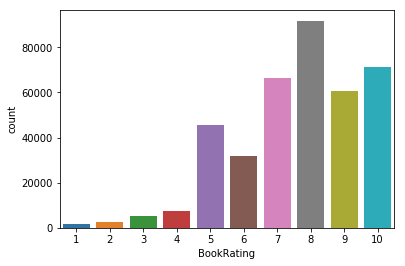

In [69]:
sns.countplot(data=ratings_explicit,x='BookRating')
plt.show()

# **Collaborative Filtering based Recommending System**


To cope up with computing power my machine has and to reduce the dataset size, I am considering users who have rated at least 100 books and books which have at least 2100 ratings.


In [0]:
count1=ratings_explicit['userid'].value_counts()

In [71]:
count1[count1>=100]

11676     6943
98391     5691
189835    1899
153662    1845
23902     1180
235105    1020
76499     1012
171118    962 
16795     959 
248718    941 
56399     837 
197659    781 
35859     777 
185233    698 
95359     606 
114368    603 
158295    567 
101851    563 
177458    524 
204864    504 
93047     501 
69078     499 
182085    498 
135149    487 
100906    484 
107784    482 
78973     479 
23872     478 
60244     476 
257204    475 
         ...  
250405    104 
35836     104 
164096    104 
113270    104 
183958    104 
163804    104 
132492    103 
164323    103 
2110      103 
148966    102 
10560     102 
76223     102 
193898    102 
86189     102 
235935    102 
66942     101 
146113    101 
224525    101 
109901    101 
172888    101 
117384    101 
36299     100 
169682    100 
211919    100 
156300    100 
95010     100 
33145     100 
26544     100 
208406    100 
36609     100 
Name: userid, Length: 449, dtype: int64

In [0]:
ratings_explicit=ratings_explicit[ratings_explicit['userid'].isin(count1[count1>=100].index)]

In [0]:
counts=ratings_explicit['BookRating'].value_counts()

In [75]:
counts[counts>100].index

Int64Index([8, 10, 9, 7, 5, 6, 4, 3, 2, 1], dtype='int64')

In [0]:
ratings_explicit=ratings_explicit[ratings_explicit['BookRating'].isin(counts[counts>=100].index)]

In [77]:
ratings_explicit

,userid,ISBN,BookRating
1456,277427,002542730X,10
1458,277427,003008685X,8
1461,277427,0060006641,10
1465,277427,0060542128,7
1474,277427,0061009059,9
1477,277427,0062507109,8
1483,277427,0132220598,8
1488,277427,0140283374,6
1490,277427,014039026X,8
1491,277427,0140390715,7


In [0]:
rating_matrix=ratings_explicit.pivot(index='userid',columns='ISBN',values='BookRating')

In [79]:
rating_matrix

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,...,987960170X,9974643058,999058284X,9992003766,9992059958,9993584185,9994256963,9994348337,9997405137,9997406567,9997406990,999740923X,9997409728,9997411757,9997411870,9997412044,9997412958,9997507002,999750805X,9997508769,9997512952,9997519086,9997555635,9998914140,B00001U0CP,B00005TZWI,B00006CRTE,B00006I4OX,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
n_users = rating_matrix.shape[0] #considering only those users who gave explicit ratings
n_books = rating_matrix.shape[1]
print (n_users)
print(n_books)

449
66574


In [0]:
rating_matrix.fillna(0, inplace = True)
rating_matrix = rating_matrix.astype(np.int32)

In [82]:
rating_matrix.head(5)

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,...,987960170X,9974643058,999058284X,9992003766,9992059958,9993584185,9994256963,9994348337,9997405137,9997406567,9997406990,999740923X,9997409728,9997411757,9997411870,9997412044,9997412958,9997507002,999750805X,9997508769,9997512952,9997519086,9997555635,9998914140,B00001U0CP,B00005TZWI,B00006CRTE,B00006I4OX,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
global metric,k
k=10
metric='cosine'

# **User-based Recommendation System**

In [0]:
#This function finds k similar users given the user_id and ratings matrix 
#These similarities are same as obtained via using pairwise_distances
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

In [0]:
#This function predicts rating for specified user-item combination based on user-based approach
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

In [86]:
predict_userbased(11676,'0001056107',rating_matrix)


Predicted rating for user 11676 -> item 0001056107: 2


2

# **Item-based Recommendation Systems**

In [0]:
def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [0]:
#This function predicts the rating for specified user-item combination based on item-based approach
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings) #similar users based on correlation coefficients
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below //code has been validated without the code snippet below, below snippet is to avoid negative
    #predictions which might arise in case of very sparse datasets when using correlation metric
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))     
    
    return prediction

In [90]:
prediction = predict_itembased(11676,'0001056107',rating_matrix)


Predicted rating for user 11676 -> item 0001056107: 1


In [0]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [0]:
#This function utilizes above functions to recommend items for item/user based approach and cosine/correlation. 
#Recommendations are made if the predicted rating for an item is >= to 6,and the items have not been rated already
def recommendItem(user_id, ratings, metric=metric):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print ("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(rating_matrix.index.values))))
    else:    
        ids = ['Item-based (correlation)','Item-based (cosine)','User-based (correlation)','User-based (cosine)']
        select = widgets.Dropdown(options=ids, value=ids[0],description='Select approach', width='1000px')
        def on_change(change):
            clear_output(wait=True)
            prediction = []            
            if change['type'] == 'change' and change['name'] == 'value':            
                if (select.value == 'Item-based (correlation)') | (select.value == 'User-based (correlation)') :
                    metric = 'correlation'
                else:                       
                    metric = 'cosine'   
                with suppress_stdout():
                    if (select.value == 'Item-based (correlation)') | (select.value == 'Item-based (cosine)'):
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_itembased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                    else:
                        for i in range(ratings.shape[1]):
                            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                                prediction.append(predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric))
                            else:                    
                                prediction.append(-1) #for already rated items
                prediction = pd.Series(prediction)
                prediction = prediction.sort_values(ascending=False)
                recommended = prediction[:10]
                print ("As per {0} approach....Following books are recommended...".format(select.value))
                for i in range(len(recommended)):
                     print ("{0}. {1}".format(i+1,books.booktitle[recommended.index[i]].encode('utf-8')))                        
        select.observe(on_change)
        display(select)

In [93]:
recommendItem(999999,rating_matrix)

User id should be a valid integer from this list :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85

In [0]:
recommendItem(2033, rating_matrix)

As per Item-based (cosine) approach....Following books are recommended...
1. b'The Black Ice (Detective Harry Bosch Mysteries)'
2. b'Shelter From The Storm'
3. b'Firewall'
4. b'Generation Warriors'
5. b'El club Dumas (edici\xc3\x83\xc2\xb3n en espa\xc3\x83\xc2\xb1ol)'
6. b'Paddle to the Amazon: The Ultimate 12,000-Mile Canoe Adventure'
7. b'A Taste of History: 10,000 Years of Food in Britain'
8. b'The Mythic Journey : The Meaning of Myth as a Guide for Life'
9. b'In the Stacks: Short Stories About Libraries and Librarians'
10. b'Stealing Freedom'


# **Simple Popularity based Recommendation System**

In [0]:
ratings_count=pd.DataFrame(ratings_explicit.groupby(['ISBN'])['BookRating'].sum())

In [0]:
ratings_count
top10=ratings_count.sort_values('BookRating',ascending=False).head(10)

In [97]:
top10

,BookRating
ISBN,
0316666343,595
059035342X,411
043935806X,409
0385504209,400
0312195516,375
0446310786,358
0439139597,331
0345370775,320
0439064864,314


In [98]:
print("Following are the Trending Books")
top10.merge(books,left_index=True,right_on='ISBN')


Following are the Trending Books


,BookRating,ISBN,booktitle,bookAuthor,yearofpulblication,publisher
408,595,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
2143,411,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999.0,Arthur A. Levine Books
5506,409,043935806X,Harry Potter and the Order of the Phoenix (Book 5),J. K. Rowling,2003.0,Scholastic
748,400,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday
522,375,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA
37,358,0446310786,To Kill a Mockingbird,Harper Lee,1988.0,Little Brown &amp; Company
5431,331,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000.0,Scholastic
1195,320,0345370775,Jurassic Park,Michael Crichton,1999.0,Ballantine Books
5432,314,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999.0,Scholastic
3839,300,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999.0,Scholastic
